# Data Scientist Challenge LATAM

> Candidate : Emiliano Moreno

> Location : Santiago, CL

> Mail Box : emilianomm@uc.cl (Academic) / emilianoam@proton.me (Personal)

> Phone : +56 9 50983241 (CL)


## Challenge Briefing

In this challenge I'll be presenting ...

## Initial analysis 

### Importing modules and data

In [630]:
# imports

# modules
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# other
from sklearn.model_selection import train_test_split


In [631]:
# load data

# Note that values are sorted by the scheduled date

data_raw = pd.read_csv("dataset_SCL.csv", parse_dates=["Fecha-I", "Fecha-O"],
    dtype = {
        'Vlo-I' : 'str',
        'Ori-I' : 'str',
        'Des-I' : 'str',
        'Emp-I' : 'str',
        'Vlo-O' : 'str',
        'Ori-O' : 'str',
        'Des-O' : 'str',
        'Emp-O' : 'str',
        'DIA'   : 'int64',
        'MES'   : 'int64',
        'AÑO'   : 'int64',
        'DIANOM': 'str',
        'TIPOVUELO': 'str',
       'OPERA'   : 'str',
       'SIGLAORI': 'str',
       'SIGLADES': 'str'
    }).sort_values('Fecha-I', ascending=True).reset_index()

# Check dates
data_raw[["Fecha-I", "Fecha-O"]].head()

,Fecha-I,Fecha-O
0,2017-01-01 00:15:00,2017-01-01 00:04:00
1,2017-01-01 01:15:00,2017-01-01 01:10:00
2,2017-01-01 01:23:00,2017-01-01 01:29:00
3,2017-01-01 01:33:00,2017-01-01 01:38:00
4,2017-01-01 01:42:00,2017-01-01 01:40:00


In [632]:
# first look
data_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      68206 non-null  int64         
 1   Fecha-I    68206 non-null  datetime64[ns]
 2   Vlo-I      68206 non-null  object        
 3   Ori-I      68206 non-null  object        
 4   Des-I      68206 non-null  object        
 5   Emp-I      68206 non-null  object        
 6   Fecha-O    68206 non-null  datetime64[ns]
 7   Vlo-O      68205 non-null  object        
 8   Ori-O      68206 non-null  object        
 9   Des-O      68206 non-null  object        
 10  Emp-O      68206 non-null  object        
 11  DIA        68206 non-null  int64         
 12  MES        68206 non-null  int64         
 13  AÑO        68206 non-null  int64         
 14  DIANOM     68206 non-null  object        
 15  TIPOVUELO  68206 non-null  object        
 16  OPERA      68206 non-null  object       

In [633]:
# Inspect missing values

data_raw.notna().sum()

index        68206
Fecha-I      68206
Vlo-I        68206
Ori-I        68206
Des-I        68206
Emp-I        68206
Fecha-O      68206
Vlo-O        68205
Ori-O        68206
Des-O        68206
Emp-O        68206
DIA          68206
MES          68206
AÑO          68206
DIANOM       68206
TIPOVUELO    68206
OPERA        68206
SIGLAORI     68206
SIGLADES     68206
dtype: int64

In [634]:
# Identify the missing value

data_raw.iloc[
    int(np.where(data_raw['Vlo-O'].isna())[0]),
    ]

index                        6068
Fecha-I       2017-01-19 11:00:00
Vlo-I                         200
Ori-I                        SCEL
Des-I                        SPJC
Emp-I                         LAW
Fecha-O       2017-01-19 11:03:00
Vlo-O                         NaN
Ori-O                        SCEL
Des-O                        SPJC
Emp-O                         56R
DIA                            19
MES                             1
AÑO                          2017
DIANOM                     Jueves
TIPOVUELO                       I
OPERA        Latin American Wings
SIGLAORI                 Santiago
SIGLADES                     Lima
Name: 3573, dtype: object

We can see that this only missing value is a full record with useful information in the other colums. So the decision of not deleting it is made. We rather replace the missing value with a generic one. This is not a problem when modeling, cause we can treat the generic _or replacement_ values as a category on their own.

In [635]:
# Instead assing generic (of course assuming that this Vlo-O woudn't exist in a real flight)

data_raw.loc[6068, 'Vlo-O'] = '000'
data_raw.notna().sum()

index        68206
Fecha-I      68206
Vlo-I        68206
Ori-I        68206
Des-I        68206
Emp-I        68206
Fecha-O      68206
Vlo-O        68205
Ori-O        68206
Des-O        68206
Emp-O        68206
DIA          68206
MES          68206
AÑO          68206
DIANOM       68206
TIPOVUELO    68206
OPERA        68206
SIGLAORI     68206
SIGLADES     68206
dtype: int64

###  __[Challenge 1]__ Looking at the data

Since we are dealing with categorical variables, first we check the amount of distinct value in each category

In [636]:
# Distinct values

data_raw.nunique()

index        68206
Fecha-I      53252
Vlo-I          584
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          862
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

Next, a couple of graphics are drawn in order to better understand the _relationship_ beetween this variables 

First we have a look at the destination occurrence over a year. If the time of the year is used to predict delay, it is important to understand if is a seasonal change in the destinations flown, since this may explain such a change.

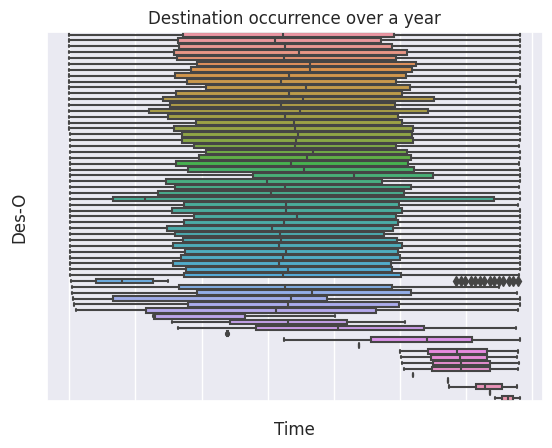

In [637]:
sns.set_theme()

# boxplot
bx_plt = sns.boxplot(data = data_raw,
            y = "Des-O", x = np.arange(data_raw.shape[0])).set(
                yticklabels=[], xticklabels=[],
                xlabel='Time',
                title='Destination occurrence over a year')




In [638]:
# Print initial and end date from the plot drawn abovedata_raw['OPERA'].unique()
print({'Date Ini' : str(data_raw['Fecha-I'][0]), 'Date End' : str(data_raw['Fecha-I'][data_raw.shape[0] - 1])})

{'Date Ini': '2017-01-01 00:15:00', 'Date End': '2017-12-31 23:55:00'}


In the above box plot, we se that most destination are operated  all of the year. A couple of destinations are only flown seasonally about the summer time.

It is also noteworthy that a couple of destinations have really little flight count, this can be due to last minute change or ocasional charter flights. In any case, this observations are likely to introduce noise and will be, hence, removed.

Now, to further confirm that there is a seasonal pattern, the total flight count per month is ploted 

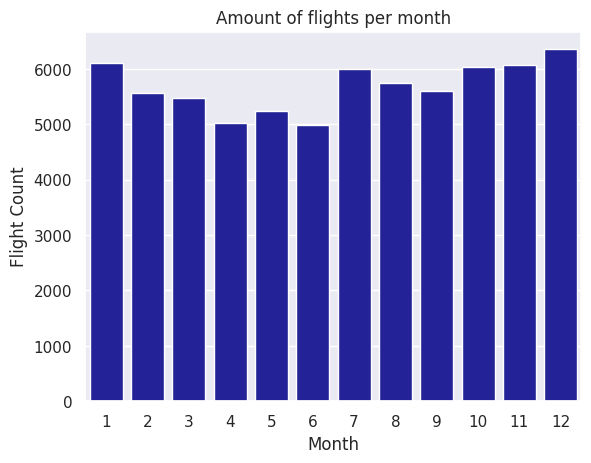

In [639]:
# Annother perspective with barplot
aux_df = pd.DataFrame(data_raw[['MES']].value_counts(sort=False), columns=['Count']).reset_index()
br_plt = sns.barplot(data = aux_df, y='Count', x='MES', orient='v', errorbar=None, color='#1010AA').set(
                xlabel='Month',
                ylabel='Flight Count',
                title='Amount of flights per month')


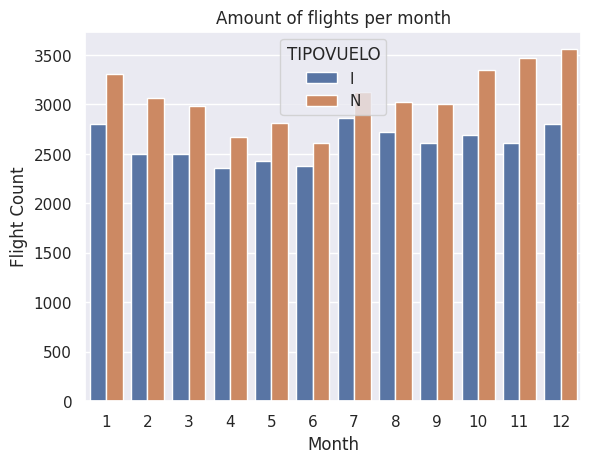

In [640]:
aux_df = pd.DataFrame(data_raw[['MES', 'TIPOVUELO']].value_counts(sort=False), columns=['Count']).reset_index()
fc_plt = sns.barplot(data = aux_df, y='Count', x='MES', hue='TIPOVUELO', orient='v', errorbar=None).set(
                xlabel='Month',
                ylabel='Flight Count',
                title='Amount of flights per month')

Clearly, there is a seasonal pattern with the total amount of flights increasing towards the summer time. A peak in July also follows from the graphic. Note that there are not major differences beetween internacional or national flights.


[Text(0.5, 1.0, 'Flight count per month per destination')]

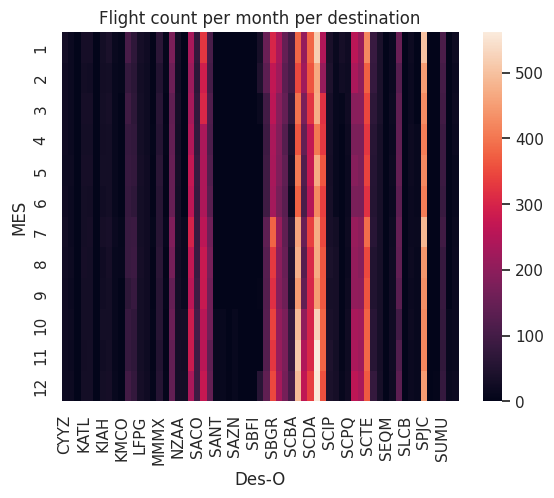

In [641]:
# By destination

# We use heatmap
aux_df2 = pd.DataFrame(data_raw[['MES', 'Des-O']].value_counts(sort=False), columns=['Count']).reset_index()
tb = pd.pivot_table(aux_df2, columns='Des-O', index='MES', values='Count', fill_value=0)
tb

sns.heatmap(tb).set(title='Flight count per month per destination')

Last, we are interested in verify if the most frequent destinations change over the year. The heatmap showing vertical lines tells us that, although changing in absolute numbers, relative to other destinations, the most frequent remain most frequent through the year. Seasonal only destinations are not visible in this last plot, due to low count.

Another interesting predictor in the data is the day of the week. We now turn the attention in spoting similar pattern as in the month

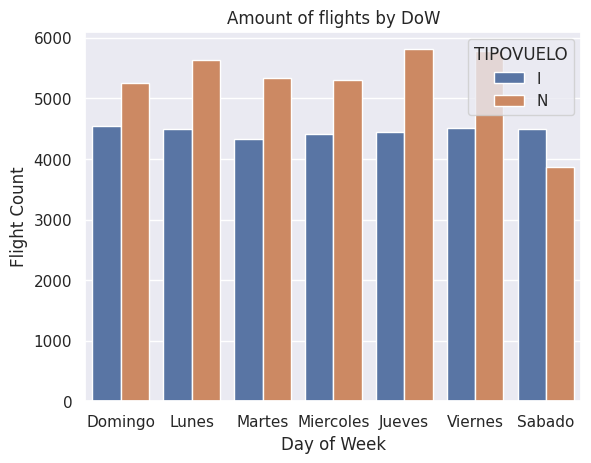

In [642]:
# Need a numeric version of DoW in order to sort properly
def name_to_num(x):
    if x=="Lunes":
        return(1)
    if x=="Martes":
        return(2)
    if x=="Miercoles":
        return(3)
    if x=="Jueves":
        return(4)
    if x=="Viernes":
        return(5)
    if x=="Sabado":
        return(6)
    if x=="Domingo":
        return(0)

# Now the plot
data_raw['DIANUM'] = data_raw['DIANOM'].apply(name_to_num)
aux_df = pd.DataFrame(data_raw[['DIANUM', 'DIANOM', 'TIPOVUELO']].value_counts(sort=False), columns=['Count']).reset_index().sort_values('DIANUM')
fc_plt = sns.barplot(data = aux_df, y='Count', x='DIANOM', hue='TIPOVUELO', orient='v', errorbar=None).set(
                xlabel='Day of Week',
                ylabel='Flight Count',
                title='Amount of flights by DoW')

As we may expect, we see an increase of domestic flights on weekends. International flights on the other hand, have a stable count through the week. This fact may have an effect if we are using the typo of flight as a predictor of delays.

###  __[Challenge 2]__ Synthetic features

This section in only for create new features that may prove useful in a prediction task.

In [643]:
# High Season

# Create a copy of the raw data to further modify the features
data_2 = data_raw

# Bounds of time intervals
s1_lo = pd.to_datetime('2017-12-15')
s1_hi = pd.to_datetime('2017-03-03')

s2_lo = pd.to_datetime('2017-07-15')
s2_hi = pd.to_datetime('2017-07-31')

s3_lo = pd.to_datetime('2017-09-11')
s3_hi = pd.to_datetime('2017-09-30')

# def. a parser function
def is_hi_season(a_date):
    if a_date >= s1_lo and a_date < s1_hi:
        return(1)

    elif a_date >= s2_lo and a_date > s2_hi:
        return(1)
    
    elif a_date >= s3_lo and a_date > s3_hi:
        return(1)
    
    else:
        return(0)


data_2['high_season'] = data_2['Fecha-I'].apply(is_hi_season)

# Minute Difference
data_2['min_dif'] = pd.to_datetime(data_2['Fecha-O']) - pd.to_datetime(data_2['Fecha-I'])

# Delay 15

# Define the treshold
delta = pd.Timedelta(15, unit='minutes')

# parser function
def is_delay_delta(t_delta, delta):
    if t_delta > delta:
        return(1)
    else:
        return(0)

# Create the feature
data_2['delay_15'] = data_2['min_dif'].apply(is_delay_delta, delta=delta)

# Period of the day

# Parser function
def get_period(a_date):
    date_hour = pd.to_datetime(a_date).hour
    if date_hour >= 5 and date_hour < 12:
        return('morning')
    
    elif date_hour >= 12 and date_hour < 19:
        return('afternoon')

    else:
        return('night')


# transform
data_2['period_day'] = data_2['Fecha-I'].apply(get_period)


# Exporting new features
# Note that, in order to get a more clean file, I am exporting ONLY the new features.
data_2[['high_season', 'min_dif', 'delay_15', 'period_day']].to_csv('synthetic_features.csv', index=False)


### __[Challenge 3]__ Behavior of delays vs other variables

To have a first impression, lets generate some barplots.

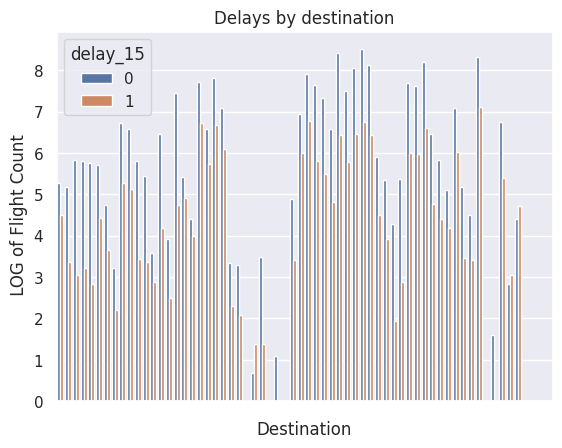

In [644]:
# Destination
# Note the use of log scale to prevennt extreme values make the plot a mess 
aux_df = pd.DataFrame(data_2[['delay_15', 'Des-I']].value_counts(sort=False), columns=['Count']).reset_index()
aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='Des-I', hue='delay_15', orient='v', errorbar=None).set(
                xticklabels=[],
                xlabel='Destination',
                ylabel=' LOG of Flight Count',
                title='Delays by destination')

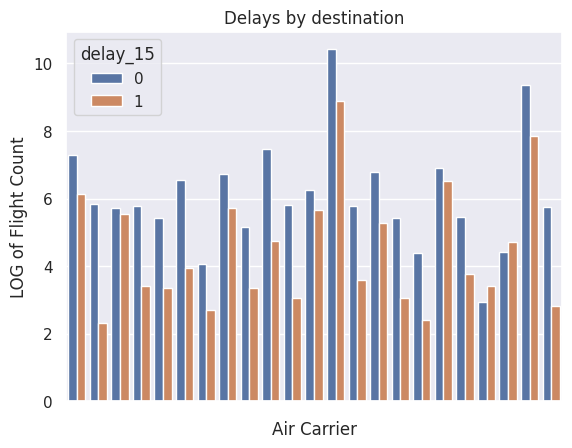

In [645]:
# Airline
# Note the use of log scale to prevennt extreme values make the plot a mess 
aux_df = pd.DataFrame(data_2[['delay_15', 'OPERA']].value_counts(sort=False), columns=['Count']).reset_index()
aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='OPERA', hue='delay_15', orient='v', errorbar=None).set(
                xticklabels=[],
                xlabel='Air Carrier',
                ylabel='LOG of Flight Count',
                title='Delays by destination')

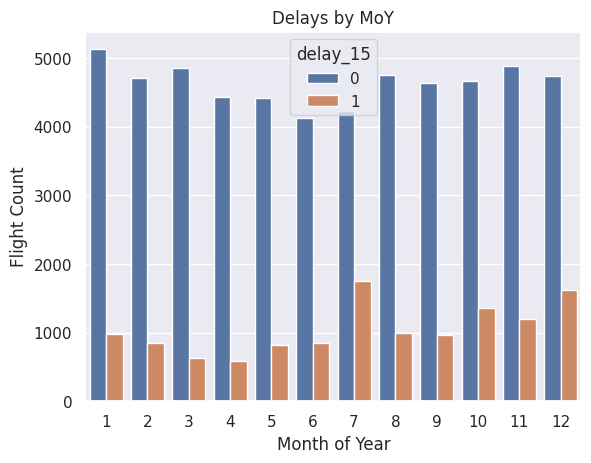

In [646]:
# Month
# No log
aux_df = pd.DataFrame(data_2[['delay_15', 'MES']].value_counts(sort=False), columns=['Count']).reset_index()
# aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='MES', hue='delay_15', orient='v', errorbar=None).set(
                xlabel='Month of Year',
                ylabel='Flight Count',
                title='Delays by MoY')

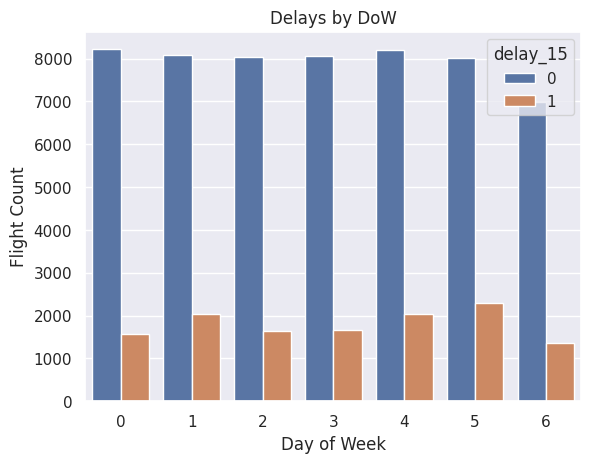

In [647]:
# Day of Week
# No log
aux_df = pd.DataFrame(data_2[['delay_15', 'DIANUM']].value_counts(sort=False), columns=['Count']).reset_index()
#aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='DIANUM', hue='delay_15', orient='v', errorbar=None).set(
                xlabel='Day of Week',
                ylabel='Flight Count',
                title='Delays by DoW')

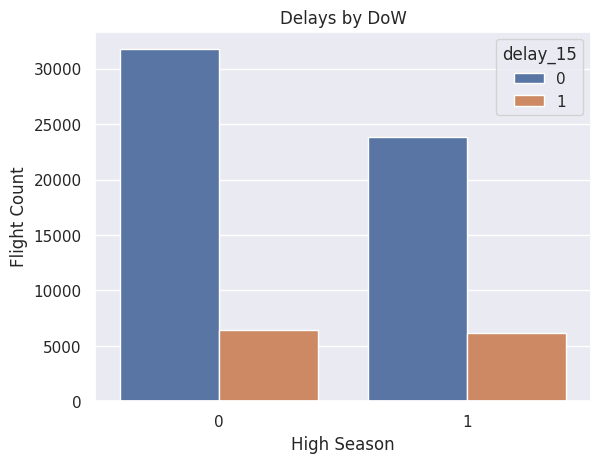

In [648]:
# Season
# No log
aux_df = pd.DataFrame(data_2[['delay_15', 'high_season']].value_counts(sort=False), columns=['Count']).reset_index()
#aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='high_season', hue='delay_15', orient='v', errorbar=None).set(
                xlabel='High Season',
                ylabel='Flight Count',
                title='Delays by DoW')

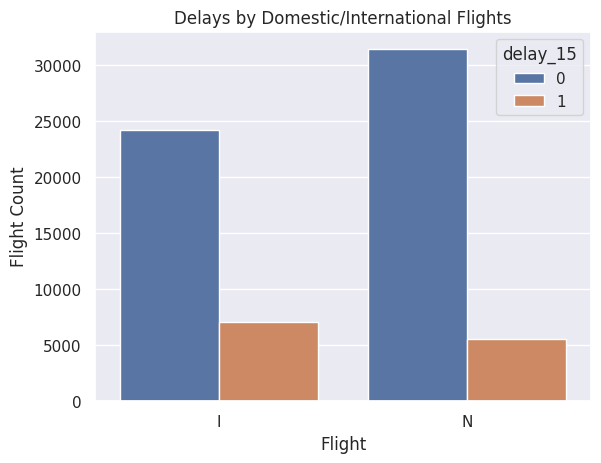

In [649]:
# Type
# No log
aux_df = pd.DataFrame(data_2[['delay_15', 'TIPOVUELO']].value_counts(sort=False), columns=['Count']).reset_index()
#aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='TIPOVUELO', hue='delay_15', orient='v', errorbar=None).set(
                xlabel='Flight',
                ylabel='Flight Count',
                title='Delays by Domestic/International Flights')

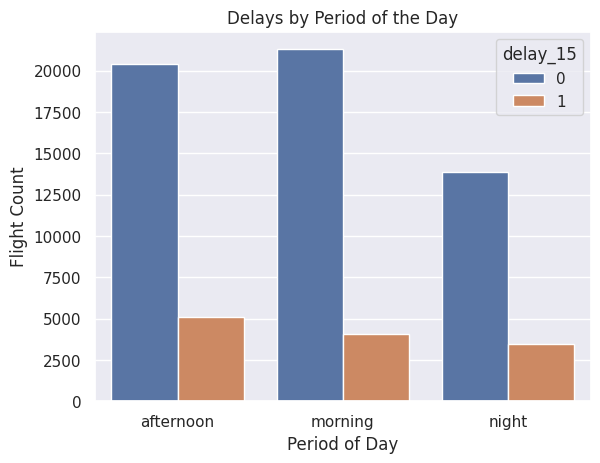

In [650]:
# Period day
# No log
aux_df = pd.DataFrame(data_2[['delay_15', 'period_day']].value_counts(sort=False), columns=['Count']).reset_index()
#aux_df['Count'] = np.log(aux_df['Count'])
fc_plt = sns.barplot(data = aux_df, y='Count', x='period_day', hue='delay_15', orient='v', errorbar=None).set(
                xlabel='Period of Day',
                ylabel='Flight Count',
                title='Delays by Period of the Day')

In summary, we can see that, since the proportions are not constant, these variable actually may have an efect on delays.

### Further changes is the data

In this section, more transformations and further cleaning of the date are made. This is done before proceed with model training.

In [651]:
# Drop destinations with very few flight count, since this may introduce noise in the model
indd = np.where(data_2['Des-I'].value_counts() <= 10 )
indd = data_2['Des-I'].isin(
    list(data_2['Des-I'].value_counts().iloc[indd].index)
)

data_2.drop(index=data_2[(indd == True)].index, inplace=True)


In [652]:
# Create indicator variable to see if the flight has been diverted to a destination different 
# from the originally scheduled.
# This is the case for a few flights
data_2['diverted'] = (data_2['Des-I'] != data_2['Des-O']).apply(int)


In [653]:
# Drop some variables and rows for training and testing
# We left with fewer predictors in order to not get reduncy

# Create dummy
dumm_period_day = pd.get_dummies(data_2['period_day'])
dumm_DIANUM = pd.get_dummies(data_2['DIANUM'])
dumm_MES = pd.get_dummies(data_2['MES'])
dumm_DIA = pd.get_dummies(data_2['DIA'])
dumm_OPERA = pd.get_dummies(data_2['OPERA'])
dumm_SIGLADES = pd.get_dummies(data_2['SIGLADES'])
dumm_TIPOVUELO = pd.get_dummies(data_2['TIPOVUELO'])

# We got dummies, now this are redundant too
# Keep on what we are interested
data_final = data_2[['delay_15', 'high_season', 'diverted' ]]

# merge data with dummies
data_final = pd.concat(
    [data_final,
    dumm_period_day,
    dumm_DIANUM,
    dumm_MES,
    dumm_DIA,
    dumm_OPERA,
    dumm_SIGLADES,
    dumm_TIPOVUELO], axis=1
)

# Verify columns inn the data
data_final.head()


,delay_15,high_season,diverted,afternoon,morning,night,0,1,2,3,...,Santa Cruz,Sao Paulo,Sydney,Temuco,Toronto,Tucuman,Valdivia,Washington,I,N
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### __[Challenge 4]__ Training the models

Now that we got a clean dataset for classification, we proceed on training the following methods

- Bernoulli Regression

- Support Vector Classifier

- Random Forest

All of this methods are well suited when dealing whith a response or _dependent variable_ that is binary.


In [654]:
# First split the data for testinnng
X_train, X_test = train_test_split(data_final, test_size=0.20)
y_train, y_test = X_train['delay_15'], X_test['delay_15'] 

X_train.drop(columns=['delay_15'], inplace=True)
X_test.drop(columns=['delay_15'], inplace=True) 

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [656]:
# Bernoulli Regression
mod_reg = LogisticRegression(solver='liblinear')
mod_reg.fit(X=X_train, y=y_train)
fitted_reg = mod_reg.predict(X=X_train)
fitted_test_reg = mod_reg.predict(X=X_test)

# Preliminary accuracy
accuracy_score(y_true=y_train, y_pred=fitted_reg)


0.8167201393344945

In [657]:
# SVC
mod_svc = LinearSVC()
mod_svc.fit(X=X_train, y=y_train)
fitted_svc = mod_svc.predict(X=X_train)
fitted_test_svc = mod_svc.predict(X=X_test)

# Preliminary accuracy
accuracy_score(y_true=y_train, y_pred=fitted_svc)

0.8164451370428087

In [658]:
# Forest
mod_rf = RandomForestClassifier()
mod_rf.fit(X=X_train, y=y_train)
fitted_rf = mod_rf.predict(X=X_train)
fitted_test_rf = mod_rf.predict(X=X_test)

# Preliminary accuracy
accuracy_score(y_true=y_train, y_pred=fitted_rf)

0.9329727747731231

### __[Challenge 5]__ Model testing

Now that we have our models trained, we proceed on making prediction with the test set.

In order to asses the performance of our various models, we use the folloinng metrics
- Recall Score
- Precision Score
- Accuracy Score
- F1 Score

Also, a _Confusion Matrix_ is presented.

In [664]:
# Computation of the metrics with test data

test_results = pd.DataFrame(
   { 
      'Recall' : {
      'Bernoulli' : recall_score(y_true=y_test, y_pred=fitted_test_reg),
      'SVC' : recall_score(y_true=y_test, y_pred=fitted_test_svc),
      'RandomForest' : recall_score(y_true=y_test, y_pred=fitted_test_rf)},

   'Precision' : {
      'Bernoulli' : precision_score(y_true=y_test, y_pred=fitted_test_reg),
      'SVC' : precision_score(y_true=y_test, y_pred=fitted_test_svc),
      'RandomForest' : precision_score(y_true=y_test, y_pred=fitted_test_rf)},

   'Accuracy' : {
      'Bernoulli' : accuracy_score(y_true=y_test, y_pred=fitted_test_reg),
      'SVC' : accuracy_score(y_true=y_test, y_pred=fitted_test_svc),
      'RandomForest' : accuracy_score(y_true=y_test, y_pred=fitted_test_rf)},

   'F1-Score' : {
      'Bernoulli' : f1_score(y_true=y_test, y_pred=fitted_test_reg),
      'SVC' : f1_score(y_true=y_test, y_pred=fitted_test_svc),
      'RandomForest' : f1_score(y_true=y_test, y_pred=fitted_test_rf)}
   }
)

test_results

,Recall,Precision,Accuracy,F1-Score
Bernoulli,0.044141,0.526316,0.818068,0.081451
SVC,0.038523,0.574850,0.819095,0.072208
RandomForest,0.215490,0.390830,0.795263,0.277807


In [684]:
# Confusion Matrix

# Bernoulli
cm_reg = confusion_matrix(y_true=y_test, y_pred=fitted_test_reg).astype(float)
cm_reg /= sum(sum(cm_reg))

# SVC
cm_svc = confusion_matrix(y_true=y_test, y_pred=fitted_test_svc).astype(float)
cm_svc /= sum(sum(cm_svc))

# RandomForest
cm_rf = confusion_matrix(y_true=y_test, y_pred=fitted_test_rf).astype(float)
cm_rf /= sum(sum(cm_rf))

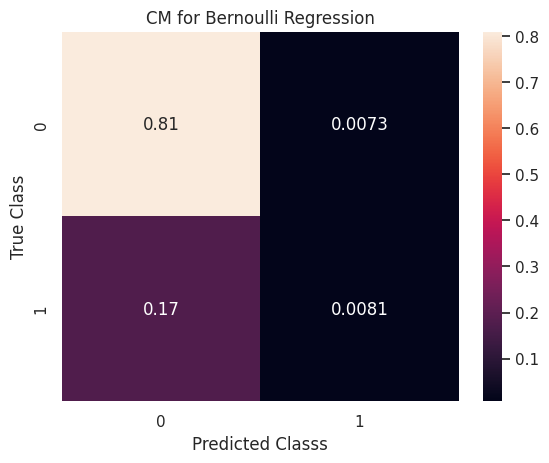

In [685]:
# Plot CM for Bernoulli Regression
sm_plt_1 = sns.heatmap(cm_reg, annot=True).set(title='CM for Bernoulli Regression',
ylabel='True Class', xlabel='Predicted Classs')

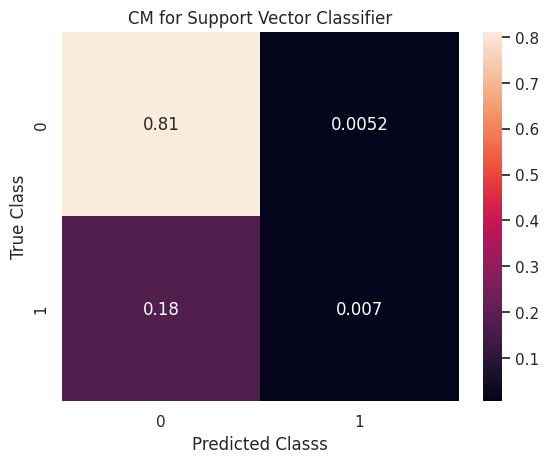

In [686]:
# Plot CM for Bernoulli Regression
cm_plt_2 = sns.heatmap(cm_svc, annot=True).set(title='CM for Support Vector Classifier',
ylabel='True Class', xlabel='Predicted Classs')

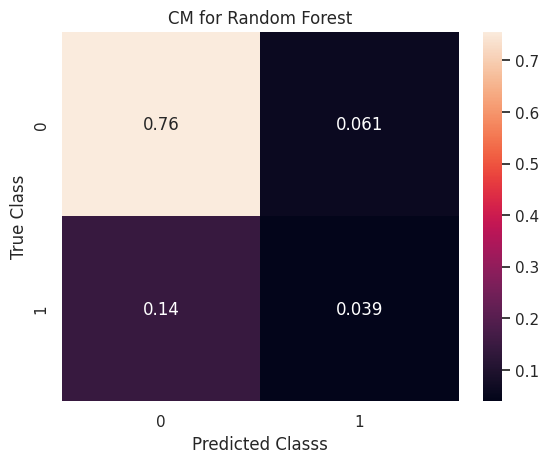

In [687]:
# Plot CM for Bernoulli Random Forest
cm_plt_3 = sns.heatmap(cm_rf, annot=True).set(title='CM for Random Forest',
ylabel='True Class', xlabel='Predicted Classs')